In [4]:
import numpy as np 
import os
import sys 

import matplotlib 
from matplotlib import pyplot as plt 
from glob import glob 

import cv2  
import gc
import math

matplotlib.use('TkAgg')
%matplotlib inline

sys.path.append("../src/")
from utils.load_tof_images import create_from_zip_absolute  as load_assignment_data
from depth_model import inference as infer


In [2]:
id = "6295be80-2857-11ed-8783-4b26e63c0e02"
path = "../data/depth_data_child/360_scan/"+id
rgb_files = glob(path+"/rgb/*")
print("Total RGB images ",len(rgb_files))

Total RGB images  26


../data/depth_data_child/360_scan/6295be80-2857-11ed-8783-4b26e63c0e02/rgb/5


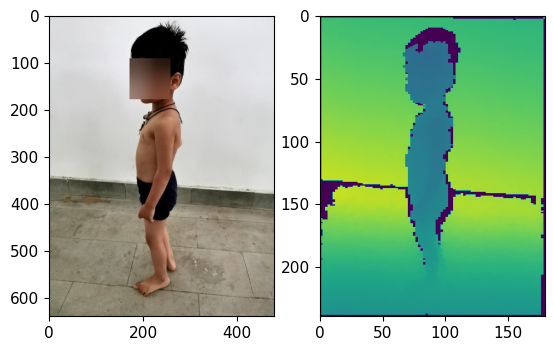

In [5]:
rgb_fpath = rgb_files[np.random.randint(0,len(rgb_files))]
print(rgb_fpath)
depth_fpath = rgb_fpath.replace('rgb','depth')
calib_fpath = os.path.dirname(rgb_fpath).replace('rgb','calibration/0')

data = load_assignment_data(rgb_fpath=rgb_fpath,depthmap_fpath=depth_fpath,calibration_fpath=calib_fpath)
rgb_image = data[8]
depth_map = data[3]

plt.subplot(1,2,1)
plt.imshow(rgb_image)
plt.subplot(1,2,2)
plt.imshow(depth_map)

In [6]:
# print properties:
print(f"Image resolution: {depth_map.shape}")
print(f"Data type: {depth_map.dtype}")
print(f"Min value: {np.min(depth_map)}")
print(f"Max value: {np.max(depth_map)}")

Image resolution: (240, 180)
Data type: float64
Min value: 0.0
Max value: 1.819


### Setting the Depth camera calibration for Asssignment dataset 

- The calibration matrix M is a 3×3 matrix:

                | fx 0   cx |
                | 0  fy  cy |
                | 0  0   1  |

Where fx, fy and cx, cy are the focal length and the optical centers

- Point cloud computing

    Computing point cloud here means transforming the depth pixel from the depth image 2D coordinate system to the depth camera 3D coordinate system (x, y and z). The 3D coordinates are computed using the following formulas, where depth(i, j) is the depth value at the row i and column j:
            
            | z = depth(i,j)       |
            | x = ( (j-cx) x z)/fx |
            | y = ( (i-cy) x z)/fy |
            
[Link](https://betterprogramming.pub/point-cloud-computing-from-rgb-d-images-918414d57e80) to info

In [7]:
# Depth camera parameters:
FX_DEPTH = 0.7811297
FY_DEPTH = 1.5166936
CX_DEPTH = 0.50329405
CY_DEPTH = 0.5187362

In [8]:
visualize = False
if visualize:
    # get depth resolution:
    height, width = depth_map.shape
    length = height * width
    # compute indices:
    jj = np.tile(range(width), height)
    ii = np.repeat(range(height), width)
    # rechape depth image
    z = depth_map.reshape(length)
    # compute pcd:
    pcd = np.dstack([(ii - CX_DEPTH) * z / FX_DEPTH,
                    (jj - CY_DEPTH) * z / FY_DEPTH,
                    z]).reshape((length, 3))

    pcd_o3d = o3d.geometry.PointCloud()  # create point cloud object
    pcd_o3d.points = o3d.utility.Vector3dVector(pcd)  # set pcd_np as the point cloud points
    # Visualize:
    o3d.visualization.draw_geometries([pcd_o3d])

### Get Image Data from the standard script provided

In [9]:
data = load_assignment_data(rgb_fpath=rgb_fpath,depthmap_fpath=depth_fpath,calibration_fpath=calib_fpath)
rgb_image = data[8]
depth_map = data[3]
depth_scale = data[4]

print(rgb_image.shape)
print(depth_map.shape)
print(depth_scale)

(640, 480, 3)
(240, 180)
0.001


In [10]:
child_bbox = infer.detect_child(rgb_image)
x1,y1,x2,y2 = child_bbox

predicted_image = infer.inference_rgbimage(rgb_image=rgb_image[y1:y2,x1:x2],depth_image_size=depth_map.shape[:2])

# torch.cuda.empty_cache()
# print("\n predicted Depth map.. Child coordinates are {}".format(child_bbox))

/home/samartht/miniconda3/envs/pyvision/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [12]:
# print properties:
print(f"Image resolution: {predicted_image.shape}")
print(f"Data type: {predicted_image.dtype}")
print(f"Min value: {np.min(predicted_image)}")
print(f"Max value: {np.max(predicted_image)}")
# predicted_image = DepthNorm(predicted_image,100)
gc.collect()

Image resolution: (240, 180)
Data type: float32
Min value: 3.060229539871216
Max value: 11.889765739440918


0

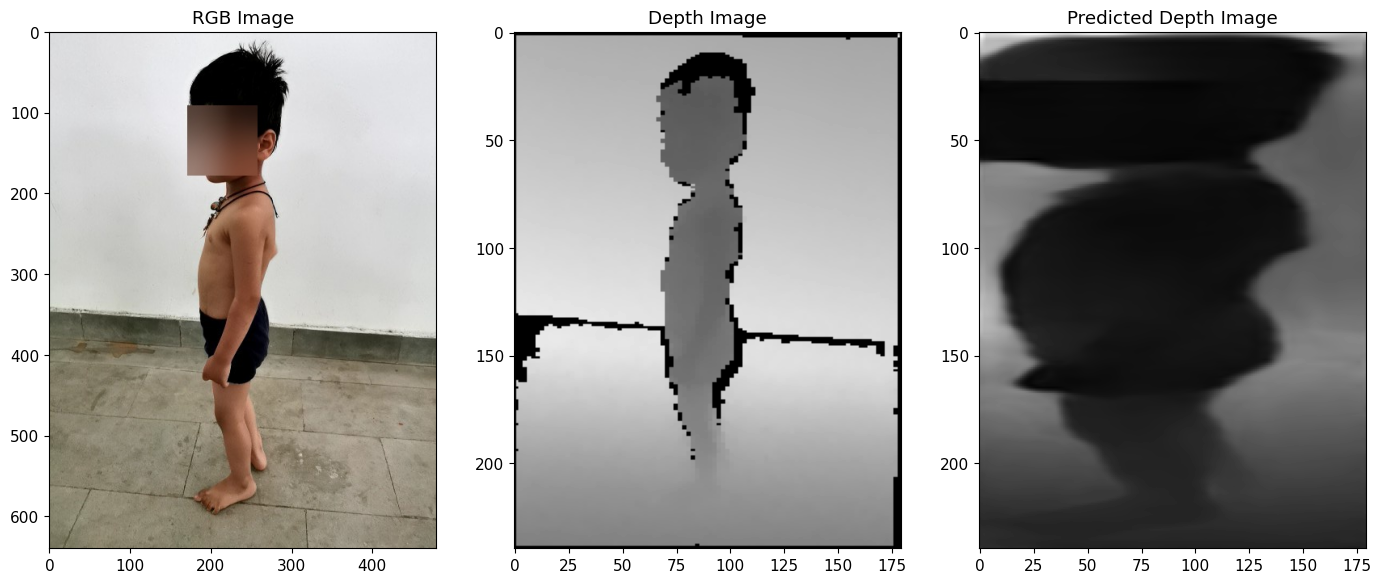

In [14]:
plt.figure(figsize=(17,19))
plt.subplot(1,3,1)
plt.title("RGB Image")
plt.imshow(rgb_image)

plt.subplot(1,3,2)
plt.title("Depth Image")
plt.imshow(data[3],cmap='gray')

plt.subplot(1,3,3)
plt.title("Predicted Depth Image")
plt.imshow(predicted_image,cmap='gray')
plt.show()
# depth_instensity = np.array(255*predicted_image/0x0fff,# / 0x0fff,
#                             dtype=np.int8)
# iio.imwrite('grayscale.png', depth_instensity)

# success, encoded_image = cv2.imencode('.png', resize)
# encoded_image.tobytes()

### create Point Cloud 

In [ ]:
# Colors:
RED = [1., 0., 0.]
GREEN = [0., 1., 0.]
BLUE = [0., 0., 1.]
YELLOW = [1., 1., 0.]
MAGENTA = [1., 0., 1.]
CYAN = [0., 1., 1.]

# get depth resolution:
colors = [RED, GREEN, BLUE, MAGENTA, YELLOW, CYAN]
height, width = predicted_image.shape
length = height * width

# compute indices:
jj = np.tile(range(width), height)
ii = np.repeat(range(height), width)

# reshape depth image
z = predicted_image.reshape(length)

# compute pcd:
pcd = np.dstack([(ii - CX_DEPTH) * z / FX_DEPTH,
                 (jj - CY_DEPTH) * z / FY_DEPTH,
                 z]).reshape((length, 3))
print("Point Cloud shape ",pcd.shape)

In [ ]:
axes = o3d.geometry.TriangleMesh.create_coordinate_frame()
pcd_o3d = o3d.geometry.PointCloud()
# create point cloud object
pcd_o3d.points = o3d.utility.Vector3dVector(pcd)  # set pcd_np as the point cloud points
pcd_o3d.estimate_normals()

In [ ]:
### Visualize:
# if visualize:
o3d.visualization.draw_geometries([pcd_o3d,axes])

###  Points with Minimum  and max values at each axis 

In [ ]:
import open3d as o3d  

x_max = max(pcd_o3d.points,key=lambda x: x[0])
y_max = max(pcd_o3d.points,key=lambda x: x[1])
z_max = max(pcd_o3d.points,key=lambda x: x[2])

x_min = min(pcd_o3d.points,key=lambda x: x[0])
y_min = min(pcd_o3d.points,key=lambda x: x[1])
z_min = min(pcd_o3d.points,key=lambda x: x[2])
positions = [x_max, y_max, z_max, x_min, y_min, z_min]

sphere = o3d.geometry.TriangleMesh.create_sphere()
geometries = [pcd_o3d, sphere]

for i in range(len(positions)):
    sphere.translate(np.asarray(positions[i]))
    # add color:
    sphere.paint_uniform_color(np.asarray(colors[i]))
    # compute normals for vertices or faces:
    sphere.compute_vertex_normals()
    # add to geometry list to display later:
    geometries.append(sphere)

o3d.visualization.draw_geometries(geometries)

In [ ]:
height = math.sqrt(z_max[2]**2 - z_min[2]**2)
round(height*10,1)

In [ ]:
# pcdchild_o3d = o3d.geometry.PointCloud()
# pcdchild_o3d.points = o3d.utility.Vector3dVector(data) 
# pcdchild_o3d.estimate_normals()
# o3d.visualization.draw_geometries([pcdchild_o3d,axes])

In [ ]:
depth_map.shape